<a href="https://colab.research.google.com/github/radwahashiesh/DeepLearningBreastCancer/blob/main/u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import images

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
import os

In [3]:
path = '/content/drive/MyDrive/Dataset_BUSI_with_GT (2)/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from keras.preprocessing.image import img_to_array

**Helper function** to get the index for real image and mask.

In [6]:
def num (image) :
    
    val = 0
    
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

<div style = "text-align: justify">Initialize the arrays for benign, normal and malignant tumors, both real and mask. As already given the number of samples in benign, normal & malignant are <b>437, 133 and 210</b> respectively.</div>

In [7]:
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m = np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [8]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

Visualize the results to verify the above method

# Create datasets for model training and validation

In [9]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [10]:
X /= 255.0
y /= 255.0

In [11]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [12]:
print(X.max())
print(X.min())

1.0
0.0


In [13]:
print(y.max())
print(y.min())

2.0
0.0


In [14]:
y[y > 1.0] = 1.0

In [15]:
print(y.max())
print(y.min())

1.0
0.0


# Visualization

<div style = "text-align: justify"> <b>Take a good look at image 2 and 8</b> and think if the masks were not provided, then would it have been easy to know the location tumor. NO !!! This is the aim of U-net model, localize the abnormalities in the image itself. Let's see the implementation.</div>

# Train test split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 1)

In [18]:
print(X_train.shape)
print(y_train.shape)

(741, 128, 128, 1)
(741, 128, 128, 1)


In [19]:
print(X_test.shape)
print(y_test.shape)

(39, 128, 128, 1)
(39, 128, 128, 1)


# Model Creation [U-net](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)
<img src = "https://miro.medium.com/max/3600/1*f7YOaE4TWubwaFF7Z1fzNw.png"/>

### Basic Architecture
<div style = "text-align: justify">U-net architecture can localize the area of interest. It was first used in Biomedical imaging. The reason it is able to <b>distinguish and localize</b> the area is by classifying every pixel in the input image. <b>So the size of input and output images is the same</b>. It comprises of two paths - <b>Contracting path and Expanding path</b>.</div>

### Contract Path
The Contracting path has two Convolutional layers and a Maxpooling layer.

### Expansive Path
<div style = "text-align: justify">The Expanding path consists of both transpose Convolutional layer and two Convolutional layers. The corresponding image from contracting path is fed to this layer for precise predictions.</div>

### Modifications
<div style = "text-align: justify">I kept the padding same so that I can get the mask of exact same dimensions as the actual image. The adam gradient descent was used with a small <b>learning rate of 0.00005</b>. Also I am planning to add BatchNormalization which was discovered after U-net. </div>

In [20]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose

from keras import Model

### Contracting path

In [21]:
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

### Bottleneck layer

In [22]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

### Expanding layer

In [23]:
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [24]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

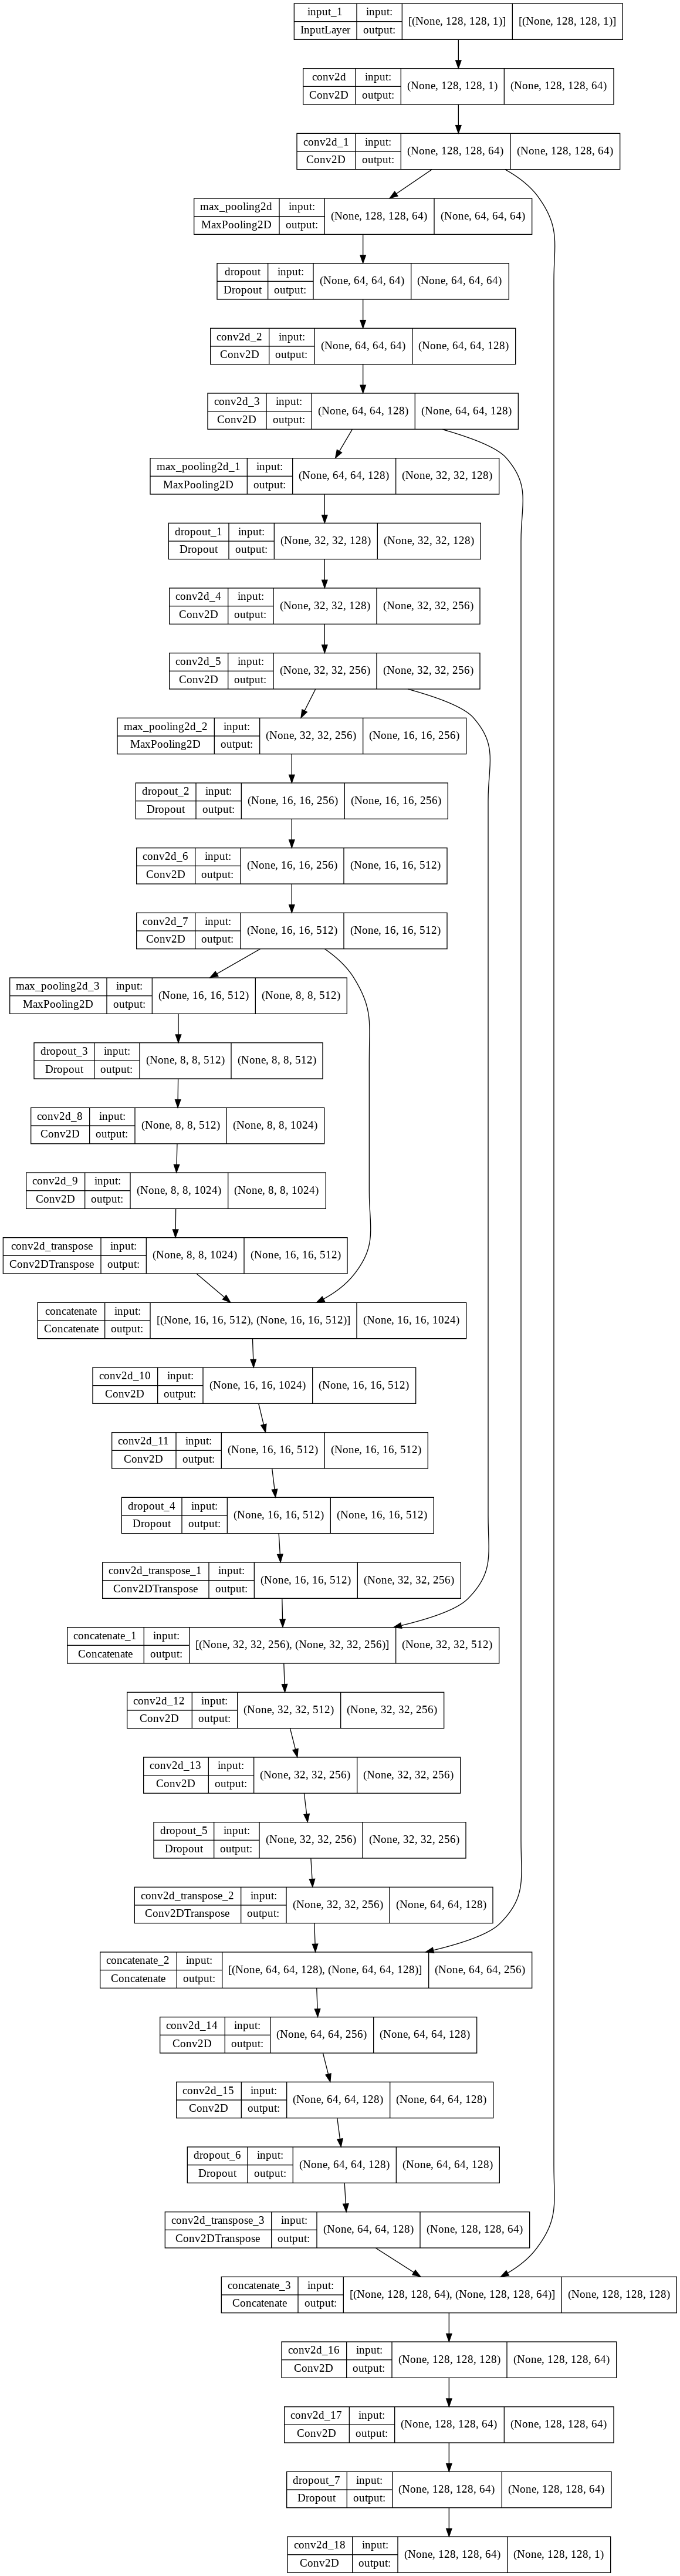

In [25]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

# Loss function

<div style = "text-align: justify">The loss for evaluating the performance of model in semantic segmentation will be <b>IoU (Intersection over Union)</b>. It is the ratio of intersection of pixels between predicted and target image over their union. The MeanIoU() method in tf.keras.metrics package can be used.</div>

In [26]:
from keras.metrics import MeanIoU

# Training

In [27]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['acc'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [28]:
from keras.callbacks import ModelCheckpoint

In [29]:
checkp = ModelCheckpoint('./unet_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

In [30]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/100
24/24 [==============================] - 33s 577ms/step - loss: 0.0754 - acc: 0.9208 - val_loss: 0.0763 - val_acc: 0.9174
Epoch 2/100
24/24 [==============================] - 9s 381ms/step - loss: 0.0732 - acc: 0.9208 - val_loss: 0.0738 - val_acc: 0.9174
Epoch 3/100
24/24 [==============================] - 9s 382ms/step - loss: 0.0695 - acc: 0.9208 - val_loss: 0.0707 - val_acc: 0.9174
Epoch 4/100
24/24 [==============================] - 9s 385ms/step - loss: 0.0633 - acc: 0.9211 - val_loss: 0.0684 - val_acc: 0.9174
Epoch 5/100
24/24 [==============================] - 9s 389ms/step - loss: 0.0576 - acc: 0.9253 - val_loss: 0.0684 - val_acc: 0.9177
Epoch 6/100
24/24 [==============================] - 9s 391ms/step - loss: 0.0530 - acc: 0.9324 - val_loss: 0.0635 - val_acc: 0.9184
Epoch 7/100
24/24 [==============================] - 9s 394ms/step - loss: 0.0540 - acc: 0.9316 - val_loss: 0.0633 - val_acc: 0.9181
Epoch 8/100
24/24 [==============================] - 10s 398ms/step 

# Model Performance

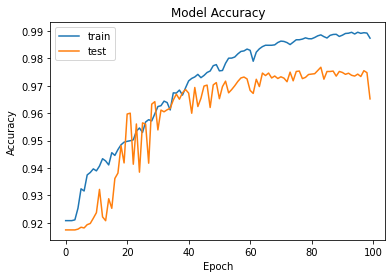

In [31]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

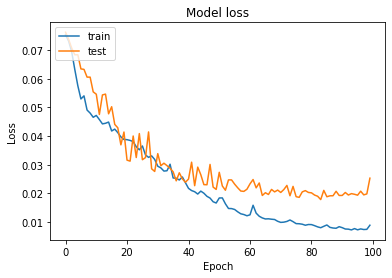

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

2/2 [==============================] - 0s 48ms/step - loss: 0.0253 - acc: 0.9652
Test loss: 0.025300519540905952
Test accuracy: 96.52146697044373


In [34]:
y_pred = model.predict(X_test)

In [35]:
print(y_pred.shape)

(39, 128, 128, 1)


In [36]:
model.save("unet.h5")